# Predicting wage

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, SplineTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, ElasticNetCV

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from joblib import dump

from scipy.optimize import curve_fit

Based on the exploratory data analysis, we decided to predict wage on the logarithmic scale. Moreover, we discovered that the variable `region` is constant on this dataset. Therefore, we remove it from the analysis.

In [2]:
data = pd.read_csv("../data/wage_model.csv")
data = data.drop(columns = ['wage', 'region'])
y = data['logwage']

In [3]:
data

,year,age,maritl,race,education,jobclass,health,health_ins,logwage
0,2003,45,2. Married,1. White,3. Some College,1. Industrial,1. <=Good,1. Yes,4.875061
1,2006,50,2. Married,1. White,5. Advanced Degree,2. Information,2. >=Very Good,2. No,5.360552
2,2003,38,2. Married,3. Asian,4. College Grad,2. Information,2. >=Very Good,2. No,5.301030
3,2005,40,4. Divorced,1. White,2. HS Grad,2. Information,2. >=Very Good,2. No,3.920123
4,2007,40,2. Married,1. White,4. College Grad,2. Information,2. >=Very Good,2. No,5.079181
...,...,...,...,...,...,...,...,...,...
995,2005,40,2. Married,1. White,4. College Grad,1. Industrial,2. >=Very Good,1. Yes,4.875061
996,2008,32,1. Never Married,1. White,4. College Grad,2. Information,2. >=Very Good,1. Yes,5.000000
997,2009,50,2. Married,2. Black,2. HS Grad,1. Industrial,2. >=Very Good,2. No,4.886491
998,2007,35,2. Married,1. White,1. < HS Grad,1. Industrial,1. <=Good,2. No,4.698970


## Data transformation

We start by transforming the data. First, we use one-hot encoding with the categorical variables. Then, we apply a Yeo-Johnson transformation followed by a spline basis expansion for the numerical variables; the former tries to correct for skewness in the data, whereas the latter will allow us to model nonlinear relationships using the regression model below.

In [4]:
column_trans = ColumnTransformer(
    [('categorical', OneHotEncoder(dtype='int'), ['maritl', 'race', 'education', 'jobclass', 
                                                  'health', 'health_ins']),
     ('sp', Pipeline([('YJ', PowerTransformer()), ('spline', SplineTransformer())]), ['year', 'age'])]
)

column_trans.fit(data)
X = column_trans.transform(data)

In [5]:
column_trans.get_feature_names_out()

array(['categorical__maritl_1. Never Married',
       'categorical__maritl_2. Married', 'categorical__maritl_3. Widowed',
       'categorical__maritl_4. Divorced',
       'categorical__maritl_5. Separated', 'categorical__race_1. White',
       'categorical__race_2. Black', 'categorical__race_3. Asian',
       'categorical__race_4. Other',
       'categorical__education_1. < HS Grad',
       'categorical__education_2. HS Grad',
       'categorical__education_3. Some College',
       'categorical__education_4. College Grad',
       'categorical__education_5. Advanced Degree',
       'categorical__jobclass_1. Industrial',
       'categorical__jobclass_2. Information',
       'categorical__health_1. <=Good',
       'categorical__health_2. >=Very Good',
       'categorical__health_ins_1. Yes', 'categorical__health_ins_2. No',
       'sp__year_sp_0', 'sp__year_sp_1', 'sp__year_sp_2', 'sp__year_sp_3',
       'sp__year_sp_4', 'sp__year_sp_5', 'sp__year_sp_6', 'sp__age_sp_0',
       'sp__age_sp

## Prediction model

We can now focus on the prediction task. Here we use an elastic net linear regression model. This approach performs feature selection while accounting for potential multicollinearity between the predictors.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2022)

In [7]:
regr = ElasticNetCV(cv=5, random_state=2022)
regr.fit(X_train, y_train)

ElasticNetCV(cv=5, random_state=2022)

In [8]:
regr.coef_

array([-0.05394085,  0.12620825,  0.        , -0.        ,  0.        ,
        0.00259339, -0.        , -0.        , -0.        , -0.14986444,
       -0.0675144 , -0.        ,  0.10128268,  0.25475344, -0.        ,
        0.        , -0.02150645,  0.02102004,  0.10165203, -0.0992383 ,
       -0.        , -0.04723871, -0.03456651,  0.        ,  0.        ,
        0.00286867,  0.        , -0.        , -0.        ,  0.        ,
        0.14259094,  0.        , -0.        , -0.        ])

We evaluate the performance of our model using the test data. We produce both numerical values and graphical assessments.

In [9]:
y_pred = regr.predict(X_test)

In [10]:
metrics_fun = [r2_score, mean_squared_error, mean_absolute_percentage_error]

metrics_res = [fun(y_test, y_pred) for fun in metrics_fun]

print (
    f'Metric | Value\n'
     '----------------\n'
    f'R2     | {metrics_res[0]:>.2%}\n'
    f'MSE    | {metrics_res[1]:>.4f}\n'
    f'RMSE   | {np.sqrt(metrics_res[1]):>.4f}\n'
    f'MAPE   | {metrics_res[2]:>.2%}\n'
)

Metric | Value
----------------
R2     | 37.53%
MSE    | 0.0793
RMSE   | 0.2816
MAPE   | 4.40%



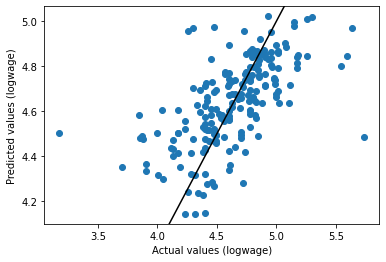

In [11]:
plt.scatter(y_test, y_pred)
plt.axline((np.mean(y_test), np.mean(y_test)), slope=1, color = 'black')
plt.xlabel("Actual values (logwage)")
plt.ylabel("Predicted values (logwage)")
plt.show()

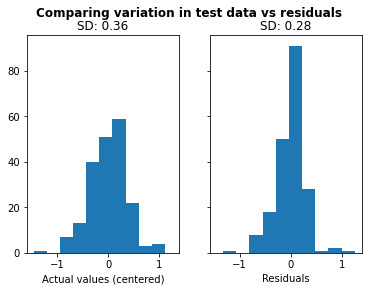

In [12]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True)
axs[0].hist(y_test - np.mean(y_test))
axs[0].set_xlabel('Actual values (centered)')
axs[0].set_title(f'SD: {np.std(y_test):.2f}')
axs[1].hist(y_test - y_pred)
axs[1].set_xlabel('Residuals')
axs[1].set_title(f'SD: {np.std(y_test - y_pred):.2f}')
fig.suptitle('Comparing variation in test data vs residuals',
             weight = 'bold')
plt.show()

Finally, we refit the model using all the data. We then save the models so that we can use them for predicting on new data.

In [13]:
final_regr = ElasticNet(alpha=regr.alpha_)
final_regr.fit(X, y)

ElasticNet(alpha=0.0043781170805865)

In [14]:
dump(column_trans, 'artifacts/column_trans.joblib')
dump(final_regr, 'artifacts/final_regr.joblib')

['artifacts/final_regr.joblib']

## Epilogue---Post-hoc sample size analysis

We can investigate the relationship between accuracy and sample size as follows. We will take subsets of the training data and fit the final model. We then compute the accuracy on the test data, and we can plot accuracy as a function of sample size. Statistical learning theory tells us that the relationship should follow a power law. Through extrapolation, we can assess what sample size would likely give us the desired accuracy.

In [15]:
rng = np.random.default_rng(seed=2022)

n, p = X_train.shape
samp_size_vec = np.arange(10, n + 10, 10)
output = np.zeros((len(samp_size_vec), 3))
y_train = y_train.reset_index(drop=True)

ss_regr = ElasticNet(alpha=regr.alpha_)

for i in range(len(samp_size_vec)):
    indices = rng.choice(n, size=samp_size_vec[i], replace = False)
    X_sub = X_train[indices,]
    y_sub = y_train[indices]
    ss_regr.fit(X_sub, y_sub)
    y_pred_ss = ss_regr.predict(X_test)
    output[i,] = [fun(y_test, y_pred_ss) for fun in metrics_fun]
    

In [16]:
def power_law(x, a, b, c):
    return a - b*np.power(x, c)

est_val, est_cov = curve_fit(power_law, samp_size_vec, output[:,0], 
                             bounds = ([0, 0, -np.Inf], [np.Inf, np.Inf, 0]))
est_val

array([ 0.39773026, 12.02398732, -0.95572732])

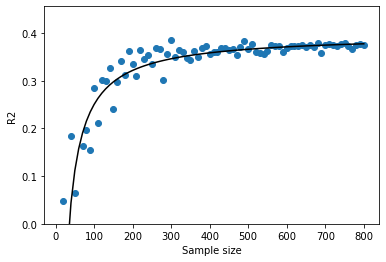

In [17]:
# E.g. R2
plt.scatter(samp_size_vec, output[:,0])
plt.plot(samp_size_vec, [power_law(x, a = est_val[0], b = est_val[1], c = est_val[2]) for x in samp_size_vec],
         color = 'black')
plt.xlabel("Sample size")
plt.ylabel("R2")
plt.ylim(bottom = 0)
plt.show()

As we can see, it is unlikely that a larger sample size would give us better accuracy. But note that it is of course possible that a *different* model could give us better accuracy.